# Convolutional Latent Neural Process (ConvLNP)

```{figure} ../images/computational_graph_ConvLNPs.png
---
height: 25em
name: computational_graph_ConvLNPs
alt: Computational graph ConvLNP
---
Computational graph for Convolutional Latent Neural Processes.
```

In this notebook we will show how to train a ConvLNP on samples from GPs and images using our framework, as well as how to make nice visualizations of sampled from ConvLNP.
We will follow quite closely the previous {doc}`LNP notebook <LNP>` and {doc}`ConvCNP notebook <ConvCNP>`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import matplotlib.pyplot as plt
import torch

os.chdir("../..")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 8
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)

## Initialization

Let's load all the data. For more details about the data and some samples, see the {doc}`data <Datasets>` notebook.

In [2]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

# DATASETS
# gp
gp_datasets, gp_test_datasets, gp_valid_datasets = get_all_gp_datasets()
# image
img_datasets, img_test_datasets = get_img_datasets(["celeba32", "mnist", "zsmms"])

Now let's define the context target splitters, which given a data point will return the context set and target set by selecting randomly selecting some points and preprocessing them so that the features are in $[-1,1]$. 
We use the same as in {doc}`ConvCNP notebook <ConvCNP>`, namely all target points and uniformly sampling in $[0,50]$ and $[0,n\_pixels * 0.3]$ for 1D and 2D respectively and the 2D splitter return the mask instead of the features to enable implementation of the "on the grid" ConvLNP with standard deep learning building blocks.

In [3]:
from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs,
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.0, b=50), targets_getter=get_all_indcs,
    )
)
get_cntxt_trgt_2d = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0.0, b=0.3), target_masker=no_masker, # used b=0.5 in paper
    ),
    is_return_masks=True,  # will be using grid conv CNP => can work directly with mask
)

Let's now define the models. We use a similar architecture as in {doc}`ConvCNP notebook <ConvCNP>` (`ConvCNP` with `ConvLNP`) the differences can be summarized as follows (in $\color{red}{\text{red}}$):


* Off the grid (GP datasets):
    1. Set convolution with normalized Gaussian RBF kernel to get a functional representation of the context set, and concatenate the density channel.
    2. Uniformly discretize (64 points per unit) the output function to enable the use of standard CNNs.
    3. $\color{red}{8}$ layer ResNet to process the functional representation with the $\color{red}{\text{output being a normal distribution at every discretized / induced point}}$.
    5. $\color{red}{\text{Sample from each Gaussian distributions independently}}$.
    6. $\color{red}{\text{8 layer ResNet to process the sample from the latent functional representation}}$. 
    7. Set Convolution with normalized Gaussian RBF kernel to enable querying at each target feature.
    8. $\color{red}{\text{Linear decoder}}$. 


* On the grid  (MNIST, CelebA32): 
    1. Apply the mask to the input image, concatenate the mask as a new (density) channel, and apply a convolutional layer.
    2. $\color{red}{8}$ layer ResNet to process the functional representation with the $\color{red}{\text{output being a normal distribution at every discretized / induced point}}$.
    3. $\color{red}{\text{Sample from each Gaussian distributions independently}}$.
    4. $\color{red}{\text{8 layer ResNet to process the sample from the latent functional representation}}$. 
    5. $\color{red}{\text{Linear decoder}}$.

ALthough we do not implement it this way, it would be very simple to implement the ConvLNP by stacking 2 ConvCNPs. The first one is used to model discretized latent function, the second is used to reintroduce dependencies between target points by taking as input a sample from the first one. 

Note that we use `is_q_zCct=False` (contrary to other LNPFs), this is because we use NPML instead of NPVI for ConvLNP. We discuss this in details in {ref}`Training LNPF <training_lnpf>`, this objective performs competitively for all LNPFs, but we only use it here for ConvLNP which is especially hard to train with NPVI.  

In [4]:
from functools import partial

from npf import ConvLNP, GridConvLNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    is_q_zCct=False,  # use NPML instead of NPVI => don't use posterior sampling
    n_z_samples_train=16,  # going to be more expensive
    n_z_samples_test=32,
    r_dim=R_DIM,
    Decoder=discard_ith_arg(
        torch.nn.Linear, i=0
    ),  # use small decoder because already went through CNN
)

CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,
    n_blocks=4,
)


# 1D case
model_1d = partial(
    ConvLNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    is_global=True,  # use some global representation in addition to local
    **KWARGS,
)

# on the grid
model_2d = partial(
    GridConvLNP,
    x_dim=1,  # for gridded conv it's the mask shape
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv2d,
        Normalization=torch.nn.BatchNorm2d,
        kernel_size=9,
        **CNN_KWARGS,
    ),
    is_global=True,  # use some global representation in addition to local
    **KWARGS,
)


# full translation equivariance
Padder = CircularPad2d


model_2d_extrap = partial(
    GridConvLNP,
    x_dim=1,  # for gridded conv it's the mask shape
    CNN=partial(
        CNN,
        Normalization=partial(torch.nn.BatchNorm2d, eps=1e-2),
        Conv=make_padded_conv(torch.nn.Conv2d, Padder),
        kernel_size=9,
        **CNN_KWARGS,
    ),
    # make first layer also padded (all arguments are defaults besides `make_padded_conv` given `Padder`)
    Conv=lambda y_dim: make_padded_conv(make_abs_conv(torch.nn.Conv2d), Padder)(
        y_dim,
        y_dim,
        groups=y_dim,
        kernel_size=11,
        padding=11 // 2,
        bias=False,
    ),
    # no global because multiple objects
    is_global=False,
    **KWARGS,
)


n_params_1d = count_parameters(model_1d())
n_params_2d = count_parameters(model_2d(y_dim=3))
print(f"Number Parameters (1D): {n_params_1d:,d}")
print(f"Number Parameters (2D): {n_params_2d:,d}")

Number Parameters (1D): 376,068
Number Parameters (2D): 487,793


For more details about all the possible parameters, refer to the docstrings of `ConvLNP` and `GridConvLNP` and the base class `NeuralProcessFamily`.

In [5]:
# ConvLNP Docstring
print(ConvLNP.__doc__)


    Convolutional latent neural process [1].

    Parameters
    ----------
    x_dim : int
        Dimension of features.

    y_dim : int
        Dimension of y values.

    is_global : bool, optional
        Whether to also use a global representation in addition to the latent one. Only if
        encoded_path = `latent`.

    CNNPostZ : Module, optional
        CNN to use after the sampling. If `None` uses the same as before sampling. Note that computations
        will be heavier after sampling (as performing on all the samples) so you might want to
        make it smaller.

    kwargs :
        Additional arguments to `ConvCNP`.

    References
    ----------
    [1] Foong, Andrew YK, et al. "Meta-Learning Stationary Stochastic Process Prediction with
    Convolutional Neural Processes." arXiv preprint arXiv:2007.01332 (2020).
    


In [6]:
# GridConvLNP Docstring
print(GridConvLNP.__doc__)


    Spacial case of Convolutional Latent Neural Process [1] when the context, targets and
    induced points points are on a grid of the same size. C.f. `GridConvCNP` for more details.

    Parameters
    ----------
    x_dim : int
        Dimension of features.

    y_dim : int
        Dimension of y values.

    is_global : bool, optional
        Whether to also use a global representation in addition to the latent one. Only if
        encoded_path = `latent`.

    CNNPostZ : Module, optional
        CNN to use after the sampling. If `None` uses the same as before sampling. Note that computations
        will be heavier after sampling (as performing on all the samples) so you might want to
        make it smaller.

    kwargs :
        Additional arguments to `ConvCNP`.

    References
    ----------
    [1] Gordon, Jonathan, et al. "Convolutional conditional neural processes." arXiv preprint
    arXiv:1910.13556 (2019).
    


### Training

The main function for training is `train_models` which trains a dictionary of models on a dictionary of datasets and returns all the trained models.
See its docstring for possible parameters. As previously discussed, we will be using `NLLLossLNPF` (approximating maximum likelihood) instead of `ELBOLossLNPF`. This means a larger variance, so we will use gradient clipping to stabilize training.

Computational Notes :
- the following will either train all the models (`is_retrain=True`) or load the pretrained models (`is_retrain=False`)
- the code will use a (single) GPU if available
- decrease the batch size if you don't have enough memory
- 30 epochs should give you descent results for the GP datasets (instead of 100)
- the model is much slower to train as there are multiple samples used during training. You can probably slightly decrease `n_z_samples_train` to accelerate training.

In [7]:
import skorch
from npf import NLLLossLNPF
from skorch.callbacks import GradientNormClipping, ProgressBar
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=NLLLossLNPF, # NPML
    chckpnt_dirname="results/pretrained/",
    device=None,
    lr=1e-3,
    decay_lr=10,
    seed=123,
    batch_size=16,  # smaller batch because multiple samples
    callbacks=[
        GradientNormClipping(gradient_clip_value=1)
    ],  # clipping gradients can stabilize training
)


# 1D
trainers_1d = train_models(
    gp_datasets,
    {"ConvLNP": model_1d},
    test_datasets=gp_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)


# replace the zsmm model
models_2d = add_y_dim(
    {"ConvLNP": model_2d}, img_datasets
)  # y_dim (channels) depend on data
models_extrap = add_y_dim({"ConvLNP": model_2d_extrap}, img_datasets)
models_2d["zsmms"] = models_extrap["zsmms"]

# 2D
trainers_2d = train_models(
    img_datasets,
    models_2d,
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    max_epochs=50,
    **KWARGS
)


--- Loading RBF_Kernel/ConvLNP/run_0 ---

RBF_Kernel/ConvLNP/run_0 | best epoch: None | train loss: -225.7376 | valid loss: None | test log likelihood: 224.6257

--- Loading Periodic_Kernel/ConvLNP/run_0 ---

Periodic_Kernel/ConvLNP/run_0 | best epoch: None | train loss: -290.1107 | valid loss: None | test log likelihood: 240.3113

--- Loading Noisy_Matern_Kernel/ConvLNP/run_0 ---

Noisy_Matern_Kernel/ConvLNP/run_0 | best epoch: None | train loss: 85.2746 | valid loss: None | test log likelihood: -85.8749

--- Loading Variable_Matern_Kernel/ConvLNP/run_0 ---

Variable_Matern_Kernel/ConvLNP/run_0 | best epoch: None | train loss: -259.9347 | valid loss: None | test log likelihood: -6854.7534

--- Loading All_Kernels/ConvLNP/run_0 ---

All_Kernels/ConvLNP/run_0 | best epoch: None | train loss: -105.7462 | valid loss: None | test log likelihood: 92.4368

--- Loading celeba32/ConvLNP/run_0 ---

celeba32/ConvLNP/run_0 | best epoch: 43 | train loss: -5108.3694 | valid loss: -5222.1083 | test

### Plots

Let's visualize how well the model performs in different settings.

#### GPs Dataset

Let's define a plotting function that we will use in this section. We'll reuse the same plotting procedure as in {doc}`LNP notebook <LNP>`.

In [8]:
from utils.ntbks_helpers import PRETTY_RENAMER, plot_multi_posterior_samples_1d
from utils.visualize import giffify


# Fix formatting for coherent GIF
plot_config_kwargs=dict(
            set_kwargs=dict(ylim=[-3, 3]), rc={"legend.loc": "upper right"}
)

def multi_posterior_gp_gif(filename, trainers, datasets, 
                           seed=123, 
                           plot_config_kwargs=plot_config_kwargs, 
                           is_plot_generator=True, 
                           fps=1,
                           sweep_values=[0, 2, 4, 6, 8, 10, 15, 20],
                           **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_1d,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=sweep_values,
        fps=fps,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        is_plot_generator=is_plot_generator,  # plot underlying GP
        is_plot_real=False,  # don't plot sampled / underlying function
        is_plot_std=True,  # plot the predictive std
        is_fill_generator_std=False,  # do not fill predictive of GP
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        plot_config_kwargs=plot_config_kwargs,
        seed=seed,
        **kwargs,
    )

##### Samples from a single GP

First, let us visualize the ConvLNP when it is trained on samples from a single GP.
We will directly evaluate in the "harder" extrapolation regime.

In [9]:
def filter_single_gp(d):
    return {k: v for k, v in d.items() if ("All" not in k) and ("Variable" not in k)}

multi_posterior_gp_gif(
    "ConvLNP_single_gp_extrap",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    left_extrap=-2,  # shift signal 2 to the right for extrapolation
    right_extrap=2,  # shift signal 2 to the right for extrapolation
    n_samples=20,  # 20 samples from the latent
)

```{figure} ../gifs/ConvLNP_single_gp_extrap.gif
---
width: 35em
name: ConvLNP_single_gp_extrap
alt: ConvLNP on single GP
---

Posterior predictive of ConvLNPs conditioned on 20 different sampled latents (Blue line with shaded area for $\mu \pm \sigma | z$) and the oracle GP (Green line with dashes for $\mu \pm \sigma$) when conditioned on contexts points (Black) from an underlying function sampled from a GP. Each row corresponds to a different kernel and ConvCNP trained on samples for the corresponding GP. The interpolation and extrapolation regime is delimited delimited by red dashes.
```

From {numref}`ConvLNP_single_gp_extrap` we see that ConvLNP performs very well and the samples are reminiscent of those from a GP, i.e., with much richer variability compared to {numref}`AttnLNP_single_gp`. 

##### Samples from GPs with varying Kernels

Let us now make the problem harder by having the ConvLNP model a stochastic process whose posterior predictive is non Gaussian. We will do so by having the following underlying generative process: sample kernel hyperparameters then sample from the GP. Note that the data generating process is not a GP (when marginalizing over kernel hyperparameters). Theoretically this could still be modeled by a LNPF as the latent variables could model the current kernel hyperparameter. This is where the use of a global representation makes sense.

In [ ]:
# data with varying kernels simply merged single kernels
single_gp_datasets = filter_single_gp(gp_test_datasets)

# use same trainer for all, but have to change their name to be the same as datasets
base_trainer_name = "All_Kernels/ConvLNP/run_0"
trainer = trainers_1d[base_trainer_name]
replicated_trainers = {}
for name in single_gp_datasets.keys():
    replicated_trainers[base_trainer_name.replace("All_Kernels", name)] = trainer

multi_posterior_gp_gif(
    "ConvLNP_kernel_gp",
    trainers=replicated_trainers,
    datasets=single_gp_datasets,
    n_samples=20,
)

```{figure} ../gifs/ConvLNP_kernel_gp.gif
---
width: 35em
name: ConvLNP_kernel_gp
alt: ConvLNP on GPs with discrete varying kernel
---
Similar to {numref}`ConvLNP_single_gp_extrap` but the training was performed on all data simultaneously. 
```

From {numref}`ConvLNP_kernel_gp` we see that ConvLNP performs quite well in this much harder setting. Indeed, it seems to model process using the periodic kernel when the number of context points is small but quickly (around 15 context points) recovers the correct underlying kernel. Note that we plot the posterior predictive of the actual underlying GP but the generating process is highly non Gaussian.

##### Samples from GPs with varying kernel hyperparameters

We will now consider a similar experiment as before, but instead of using 3 different kernels we will use range an entire range of different kernel hyperparameters (Noisy Matern Kernel with length scale in $[0.01,0.3]$). This might seem easier than the previous task, as the kernels are more similar, but it also means that the number of possible kernels is not finite and thus we are never really training or testing on sampled from the same GP.

In [11]:
def filter_hyp_gp(d):
    return {k: v for k, v in d.items() if ("Variable" in k)}


multi_posterior_gp_gif(
    "ConvLNP_vary_gp",
    trainers=filter_hyp_gp(trainers_1d),
    datasets=filter_hyp_gp(gp_test_datasets),
    n_samples=20,  # 20 samples from the latent
    seed=0,  # selected to make it clear that the GP is fitted (not oracle stochatic process)
    # change name of GP, it's not an oracle anymore but fitted
    model_labels=dict(main="Model", generator="Fitted GP"),
)

```{figure} ../gifs/ConvLNP_vary_gp.gif
---
width: 35em
name: ConvLNP_vary_gp
alt: ConvLNP on GPs with continuous varying kernel
---
Similar to the 2nd row (Noisy Matern Kernel) of {numref}`ConvCNP_single_gp_extrap` but the training was performed on sampled from Noisy Matern Kernel with different length scales in $[0.01,0.3]$. The GP (in green) corresponds to the one with the length scale in $[0.01,0.3]$ giving rise to the largest marginal likelihood.
```

From {numref}`ConvLNP_vary_gp` we see that ConvLNP is still able to perform quite well, but it predicts in a very different way than the fitted GP. Namely it doesn't really seem to change the kernel hyperparameter / global latent during training. This contrasts with the fitted GP which clearly shows that estimate of the length scale changes for different context set size. 

In [12]:
###### ADDITIONAL 1D PLOTS ######

### No RBF ###
def filter_single_gp(d):
    return {k: v for k, v in d.items() if ("Periodic" in k) or ("Noisy" in k)}


multi_posterior_gp_gif(
    "ConvLNP_norbf_gp_extrap",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    left_extrap=-2,  # shift signal 2 to the right for extrapolation
    right_extrap=2,  # shift signal 2 to the right for extrapolation
    n_samples=20,
)

### Simplistic ###


def filter_noisy(d):
    return {k: v for k, v in d.items() if ("Noisy" in k)}

multi_posterior_gp_gif(
    "ConvLNP_noisy_simple",
    trainers=filter_noisy(trainers_1d),
    datasets=filter_noisy(gp_test_datasets),
    n_samples=20,
    is_plot_generator=False,  
    plot_config_kwargs=dict(set_kwargs=dict(ylim=[-3, 3.5]), is_ax_off=True),
    is_legend=False,
    title=None,
    sweep_values=[0, 2, 4, 6, 8, 10, 15, 20, 30, 50],
    fps=1.3,  
)

In [15]:
multi_posterior_gp_gif(
    f"ConvLNP_kernel_gp_simple",
    trainers=replicated_trainers,
    datasets=single_gp_datasets,
    n_samples=20,
    is_plot_generator=False,  
    plot_config_kwargs=dict(set_kwargs=dict(ylim=[-3, 3.5]), is_ax_off=True),
    is_legend=False,
    title="Data: {data_name} | Num. Context: {n_cntxt}",
    sweep_values=[0, 2, 4, 6, 8, 10, 15, 20, 30, 50],
    fps=0.7,  
    seed=3
)

#### Image Dataset

Let us now look at images. We again will use the same plotting procedure as in {doc}`LNP notebook <LNP>`.

In [13]:
from utils.ntbks_helpers import plot_multi_posterior_samples_imgs
from utils.visualize import giffify


def multi_posterior_imgs_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_imgs,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[
            0,  
            0.005,
            0.01,
            0.02,
            0.05,
            0.1,
            0.15,
            0.2,
            0.3,
            0.5,
            "hhalf",  # horizontal half of the image
            "vhalf",  # vertival half of the image
        ],
        fps=1.,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        n_plots=3,  # images per datasets
        is_plot_std=True,  # plot the predictive std
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        plot_config_kwargs={"font_scale":0.7},
        # Fix formatting for coherent GIF
        seed=seed,
        **kwargs,
    )

In [14]:
multi_posterior_imgs_gif(
    "ConvLNP_img", trainers=trainers_2d, datasets=img_test_datasets, n_samples=3,
)

```{figure} ../gifs/ConvLNP_img.gif
---
width: 45em
name: ConvLNP_img
alt: ConvLNP on images
---

Mean and std of the posterior predictive of an ConvLNP for CelebA $32\times32$, MNIST, and ZSMM for different context sets.
```

From {numref}`ConvLNP_img` we see that ConvLNP performs similarly to ConvCNP. Namely, well when the context set is large enough and uniformly sampled, even when extrapolation is needed (ZSMM), but has difficulties when the context set is very small or when it is structured, e.g., half images.
Also note that compared to AttnLNP ({numref}`AttnLNP_img`) the variance of the posterior predictive for each sample seems much smaller. I.e. the variance is all modeled by the latent. This makes sense, as you can interpret the variance of the conditional posterior predictive to be the aleatoric uncertainty, which is probably homoskedastic (same for all pixels) in images.

Here are more samples, corresponding to specific percentiles of the test log loss.

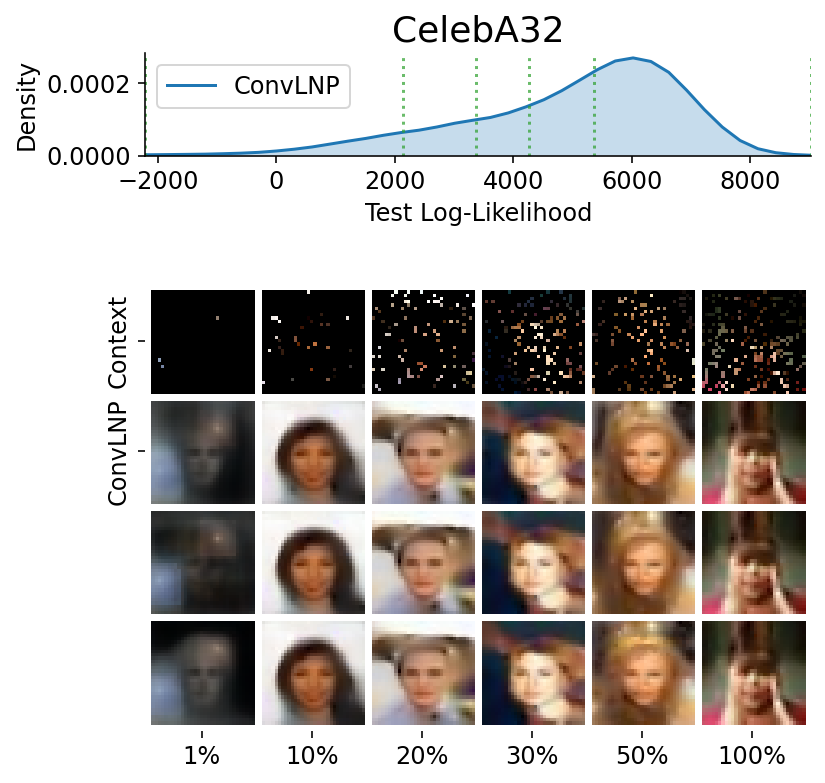

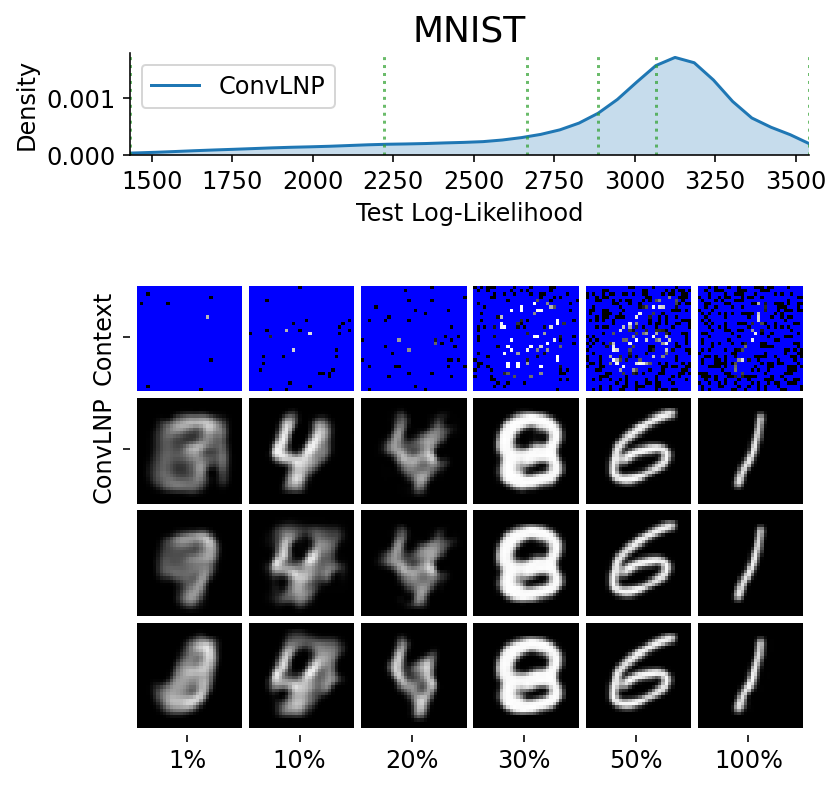

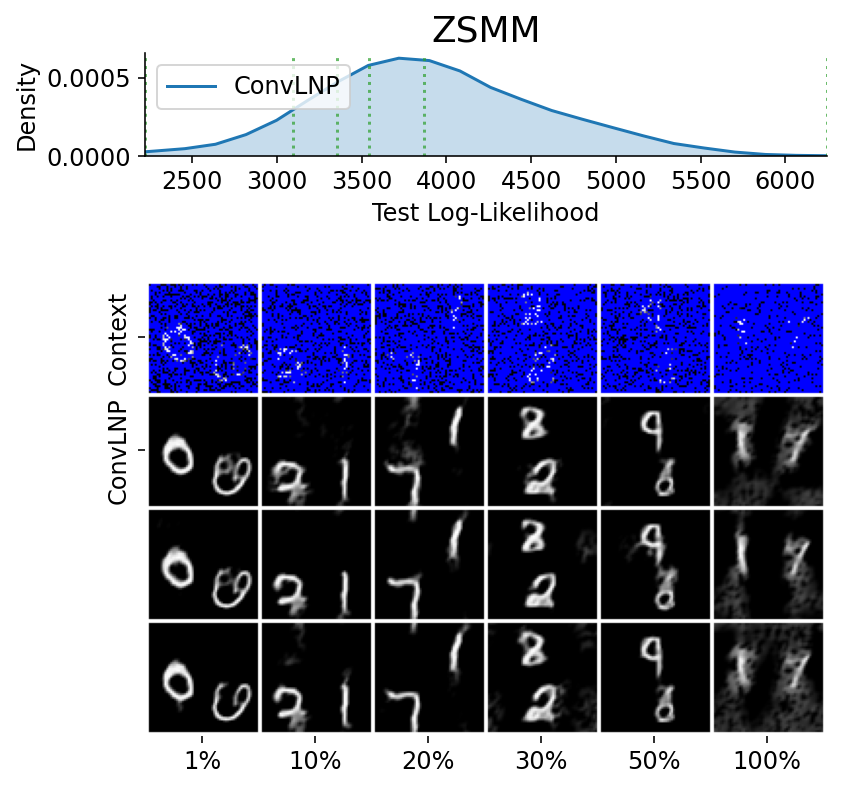

In [15]:
from utils.ntbks_helpers import PRETTY_RENAMER
from utils.visualize import plot_qualitative_with_kde

n_trainers = len(trainers_2d)
for i, (k, trainer) in enumerate(trainers_2d.items()):
    data_name = k.split("/")[0]
    model_name = k.split("/")[1]
    dataset = img_test_datasets[data_name]

    plot_qualitative_with_kde(
        [PRETTY_RENAMER[model_name], trainer],
        dataset,
        figsize=(6,6),
        percentiles=[1, 10, 20, 30, 50, 100],  # desired test percentile
        height_ratios=[1, 6],  # kde / image ratio
        is_smallest_xrange=True,  # rescale X axis based on percentile
        h_pad=0,  # padding
        title=PRETTY_RENAMER[data_name],
        upscale_factor=get_test_upscale_factor(data_name),
        n_samples=3,
    )

We have seen that a latent variable enable coherent sampling and to "switch kernel". Let us now see whether it enables a non Gaussian marginal posterior predictive.

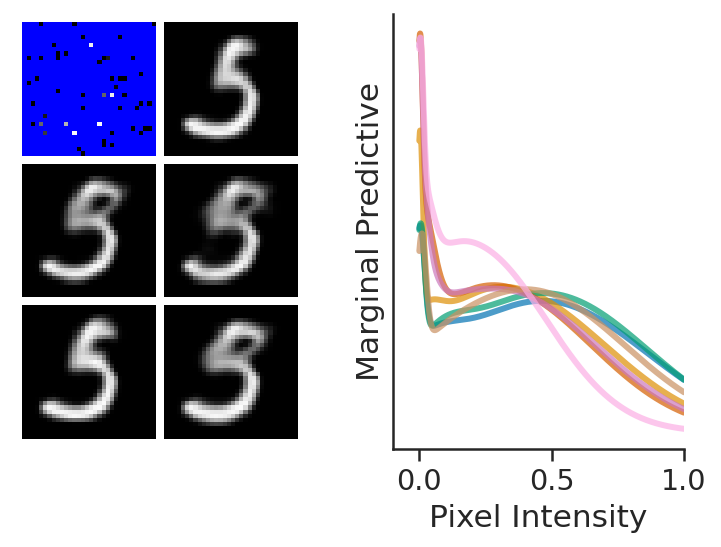

In [16]:
from utils.ntbks_helpers import select_labels
from utils.visualize import plot_config,plot_img_marginal_pred

with plot_config(font_scale=1.3, rc={"lines.linewidth": 3}):
    fig = plot_img_marginal_pred(
        trainers_2d["mnist/ConvLNP/run_0"].module_.cpu(),
        select_labels(img_test_datasets["mnist"], 3),  # Selecting a 3
        GridCntxtTrgtGetter(
            RandomMasker(a=0.05, b=0.05), target_masker=no_masker
        ),  # 5% context
        figsize=(6, 4),
        is_uniform_grid=True,  # on the grid model
        n_marginals=7,  # number of pixels posterior predictive
        n_samples=5,  # number of samples from the posterior pred
        n_columns=2,  # number of columns for the sampled
        seed=33,
    )
fig.savefig(f"jupyter/images/ConvLNP_marginal.png", bbox_inches="tight", format="jpeg", quality=80)

In the last figure, we see that, as desired, LNPFs can:
1. Give rise to coherent but varied samples
2. Model a marginal predictive distribution which is highly non Gaussian. Here we see a large spike for black pixels.

Note that we are plotting a few (7) marginal posterior predictive that are multi modal by selecting the ones that have the largest [Sarle's bimodality coefficient](https://en.wikipedia.org/wiki/Multimodal_distribution#Bimodality_coefficient) {cite}`ellison1987effect`.